In [1]:
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from functools import reduce
from pyspark.sql import functions
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
spark = SparkSession.builder \
    .appName("App_Crops_Livestock_production") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

El dataset se tomó de:https://www.fao.org/faostat/en/#data/QCL

In [3]:
df = spark.read.csv("/content/drive/MyDrive/PySpark/Production/Production_Crops_Livestock_E_All_Data.csv", header=True, inferSchema=True)
df.show()

+---------+---------------+-----------+---------+---------------+--------------------+------------+--------------+-----+---------+------+-----------------+--------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+------+---------+------+-----------------+---------+------+-----------------+---------+------+-----------------+---------+------+-----------------+---------+------+-----------------+---------+------+-----------------+---------+------+-----------------+---------+------+-----------------+---------+------+-----------------+---------+------+------+---------+------+-----------------+--------+------+-----------------+--------+------+-----------------+--------+------+----

In [4]:
len(df.columns), df.count()

(198, 78164)

Se borrarán las columnas que comienzan con Y y terminan con N, no tienen informacion relevante

In [5]:
columnas_a_borrar = [col for col in df.columns if col.startswith('Y') and col.endswith('N')]
df = df.drop(*columnas_a_borrar)

In [6]:
df = df.drop(*columnas_a_borrar)



Se borrarán las columnas que no aporten información valiosa

In [7]:
columnas_que_no_aportan = ['Area Code (M49)', 'Item Code (CPC)']
df = df.drop(*columnas_que_no_aportan)

Se borrarán las columnas con mayoria de nulos

In [8]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---------+----+---------+----+------------+-------+----+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+-----+------+
|Area Code|Area|Item Code|Item|Element Code|Element|Unit|Y1961|Y1961F|Y1962|Y1962F|Y1963|Y1963F|Y1964|Y1964F|Y1965|Y1965F|Y

In [9]:
total_filas = df.count()
nulos = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
nulos_dict = nulos.collect()[0].asDict()
columnas_con_nulos = [c for c, n in nulos_dict.items() if n / total_filas > 0.25]
df = df.drop(*columnas_con_nulos)



In [10]:
df.show()

+---------+-----------+---------+--------------------+------------+--------------+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+---------+------+---------+------+---------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+--------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+---------+------+
|Area Code|       Area|Item Code|                Item|Element Code|       Element| Unit|Y1961F|Y1962F|Y

Se borran los registros nulos

In [11]:
df = df.na.drop()


Borrando mas columnas innecesarias

In [12]:
columnas_innecesarias = [f"Y{año}F" for año in range(1961, 1986)]
df = df.drop(*columnas_innecesarias)


Borrando los registros que no tienen A,E,I,X en las columnas Y19XXF, estas letras indican como se obtuvieron los datos. A para datos oficiales,E para datos estimados por la FAO,I para datos imputados(calculados automaticamente) y X para los datos obtenidos por organizaciones externas

In [13]:
columnas_anioF = [c for c in df.columns if re.match(r"Y(?:19|20)\d{2}F", c)]
letras_permitidas = ["A", "E", "I","X"]
cond = None
for c in columnas_anioF:
    # aseguramos que el valor esté en mayúscula
    expr = functions.upper(functions.col(c)).isin(letras_permitidas)
    cond = expr if cond is None else cond | expr

df_filtrado = df.filter(cond)


Ahora se dejarán solo las columnas con los valores de cada año y se cambiarán el respectivo nombre de la columna de YXXXX a XXXX,donde XXXX es solamente el año

In [14]:
columnas_terminadas_enF = [c for c in df.columns if c.endswith("F")]
df_filtrado = df_filtrado.drop(*columnas_terminadas_enF)
columnas_anio = [c for c in df_filtrado.columns if c.startswith("Y")]
for c in columnas_anio:
    df_filtrado = df_filtrado.withColumnRenamed(c, c[1:])
df_filtrado.persist()
df_filtrado.show()

+---------+-----------+---------+--------------------+------------+--------------+-----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|Area Code|       Area|Item Code|                Item|Element Code|       Element| Unit|     1986|     1987|     1988|     1989|     1990|     1991|     1992|     1993|     1994|     1995|     1996|     1997|     1998|     1999|     2000|     2001|     2002|     2003|     2004|     2005|     2006|     2007|     2008|     2009|     2010|     2011|     2012|     2013|     2014|     2015|     2016|     2017|     2018|     2019|     2020|     2021|     2022|     2023|
+---------+-----------+---------+--------------------+--------

Lista con los años desde 1986 hasta 2023

In [15]:
anios = [str(año) for año in range(1986, 2024)]

Expresion para crear una nueva fila por cada año con su respectivo valor

In [16]:
expr = "stack({0}, {1}) as (Year, value)".format(len(anios), ",".join([f"'{col}', `{col}`" for col in anios]) )

***Producción de maiz desde 1986 hasta 2023 teniendo en cuenta los cinco continentes, el código 5510 indica la produccion en toneladas***

In [17]:
df_produccion= df_filtrado.filter((df_filtrado["Element"] == "Production") & (df_filtrado["Element Code"] == 5510))
df_maiz = df_produccion.filter(df_produccion["Item"] == "Maize (corn)")
continente = ["Americas","Asia","Europe","Africa","Oceania"]
df_maiz_anual = df_maiz.filter(df_maiz["Area"].isin(continente))
df_maiz_anual = df_maiz_anual.select(*[functions.sum(functions.col(a)).alias(a) for a in anios])
df_maiz_anual = df_maiz_anual.select(functions.expr(expr))
df_maiz_anual = df_maiz_anual.orderBy("Year")
df_maiz_anual = df_maiz_anual.withColumnRenamed("value", "produccion_total")
df_maiz_anual.show()


+----+--------------------+
|Year|    produccion_total|
+----+--------------------+
|1986|        4.78176534E8|
|1987|        4.53115706E8|
|1988|        4.03050141E8|
|1989|         4.7687441E8|
|1990|4.8338790133000004E8|
|1991|      4.9436700725E8|
|1992|      5.3374087445E8|
|1993|       4.771777629E8|
|1994|      5.6861476183E8|
|1995|5.1724758978000003E8|
|1996| 5.860920496700001E8|
|1997| 5.843529719200001E8|
|1998| 6.150213045899999E8|
|1999| 6.073653184599999E8|
|2000| 5.919549954200001E8|
|2001|      6.1507517912E8|
|2002|      6.0346846907E8|
|2003|      6.4497253472E8|
|2004| 7.294312201700001E8|
|2005|      7.1408569636E8|
+----+--------------------+
only showing top 20 rows



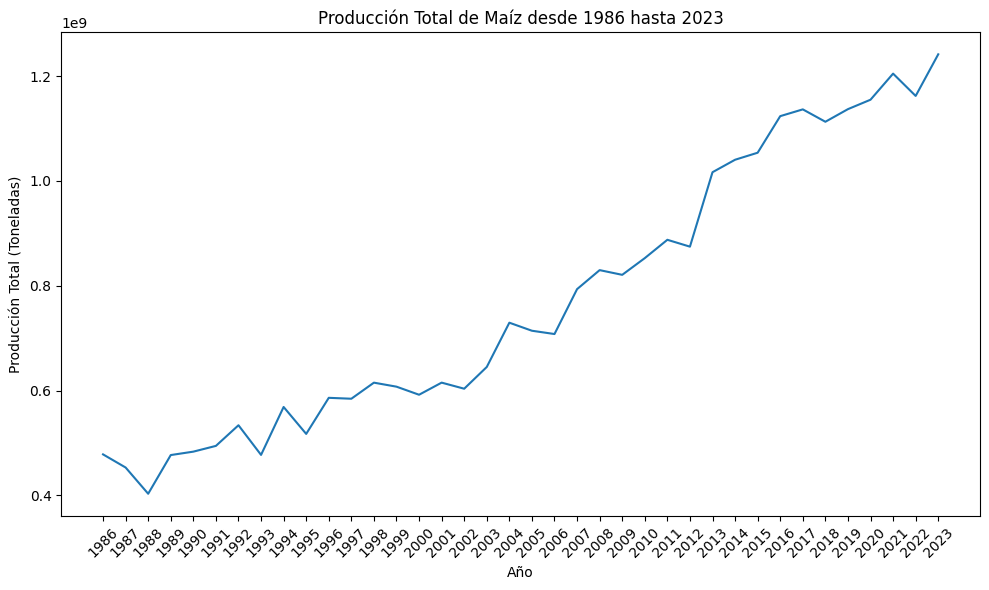

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_maiz_anual.toPandas(), x="Year", y="produccion_total")
plt.xlabel("Año")
plt.ylabel("Producción Total (Toneladas)")
plt.title("Producción Total de Maíz desde 1986 hasta 2023")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*   La producción total de maíz muestra una tendencia creciente a lo largo del tiempo, pasando de aproximadamente 0.45 mil millones de toneladas en 1986 a más de 1.2 mil millones en 2023.
*   Se observan pequeñas caídas interanuales en algunos puntos, pero la tendencia general es claramente ascendente.
*   Esto puede reflejar incrementos en la demanda global de maíz, mejoras en la productividad y expansión de áreas cultivadas.






***Área cultivada de naranjas a lo largo de los años teniendo en cuenta los cinco continentes***

In [19]:
df_area_cultivada = df_filtrado.filter(df_filtrado["Element"] == "Area harvested")
df_naranjas = df_area_cultivada.filter(df_filtrado["Item"] == "Oranges")
continente = ["Americas","Asia","Europe","Africa","Oceania"]
df_naranjas = df_naranjas.filter(df_naranjas["Area"].isin(continente))
df_naranjas = df_naranjas.select(*[functions.sum(functions.col(a)).alias(a) for a in anios])
df_area_cultivada_anual_naranjas = df_naranjas.select(functions.expr(expr))
df_area_cultivada_anual_naranjas = df_area_cultivada_anual_naranjas.orderBy("Year")
df_area_cultivada_anual_naranjas = df_area_cultivada_anual_naranjas.withColumnRenamed("value", "Area_cultivada_total(ha)")
df_area_cultivada_anual_naranjas.show()


+----+------------------------+
|Year|Area_cultivada_total(ha)|
+----+------------------------+
|1986|               2689075.0|
|1987|               2840703.0|
|1988|               2954847.0|
|1989|               3092604.0|
|1990|               3159602.0|
|1991|               3171403.0|
|1992|               3235546.0|
|1993|               3146640.0|
|1994|               3346134.0|
|1995|               3393440.0|
|1996|               3624387.0|
|1997|               3707429.0|
|1998|               3567911.0|
|1999|               3632832.0|
|2000|               3529207.0|
|2001|               3476528.0|
|2002|               3534039.0|
|2003|               3534950.0|
|2004|               3665260.0|
|2005|               3632133.0|
+----+------------------------+
only showing top 20 rows



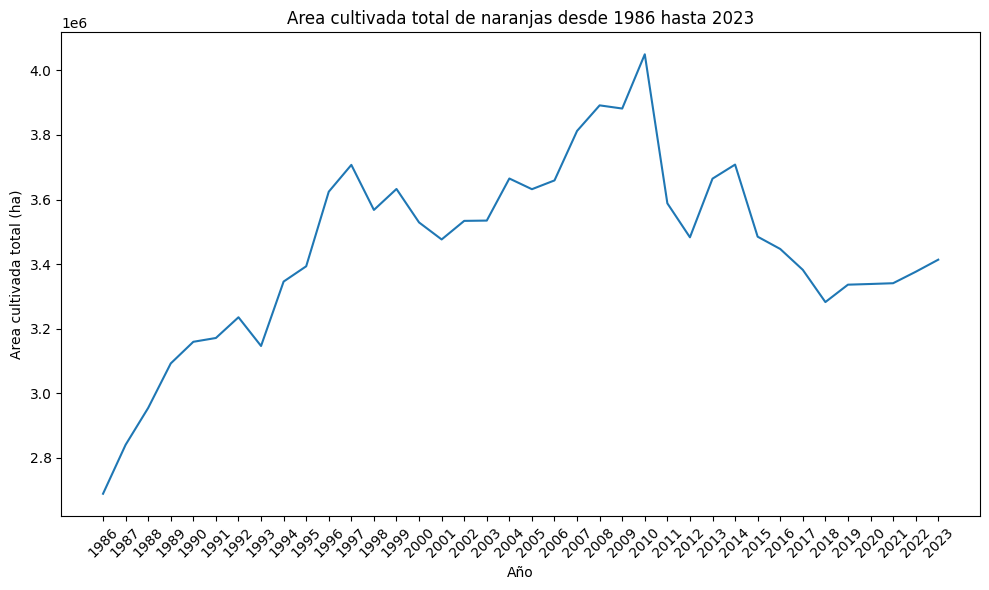

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_area_cultivada_anual_naranjas.toPandas(), x="Year", y="Area_cultivada_total(ha)")
plt.xlabel("Año")
plt.ylabel("Area cultivada total (ha)")
plt.title("Area cultivada total de naranjas desde 1986 hasta 2023")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* El área cultivada de naranjas muestra crecimientos y caídas periódicas, con picos alrededor de 2010.

* Después de 2010, se observa una reducción y estabilización de la superficie cultivada en torno a los 3.3-3.4 millones de hectáreas.

* Indica que aunque el cultivo se mantuvo relativamente estable, hubo ajustes en la expansión de tierras destinadas a naranja, posiblemente por factores económicos o climáticos.

***Promedio de producción por hectárea de papas por continente***

In [21]:
df_prod_hectarea = df_filtrado.filter((df_filtrado["Element"] == "Yield") & (df_filtrado["Element Code"] == 5412))
df_papa = (
    df_prod_hectarea
    .filter(functions.col("Item") == "Potatoes")
    .filter(functions.col("Area").isin(["Americas", "Asia", "Europe", "Africa", "Oceania"]))
    .select("Area", *anios)
    .select("Area", functions.expr(expr))
    .groupBy("Area")
    .agg(functions.avg("value").alias("promedio_produccion_por_hectarea"))
)

df_papa.show()

+--------+--------------------------------+
|    Area|promedio_produccion_por_hectarea|
+--------+--------------------------------+
|  Europe|              18549.936842105264|
|  Africa|              12646.394736842105|
|Americas|              23511.599999999995|
| Oceania|              36290.547368421045|
|    Asia|               16807.01315789474|
+--------+--------------------------------+



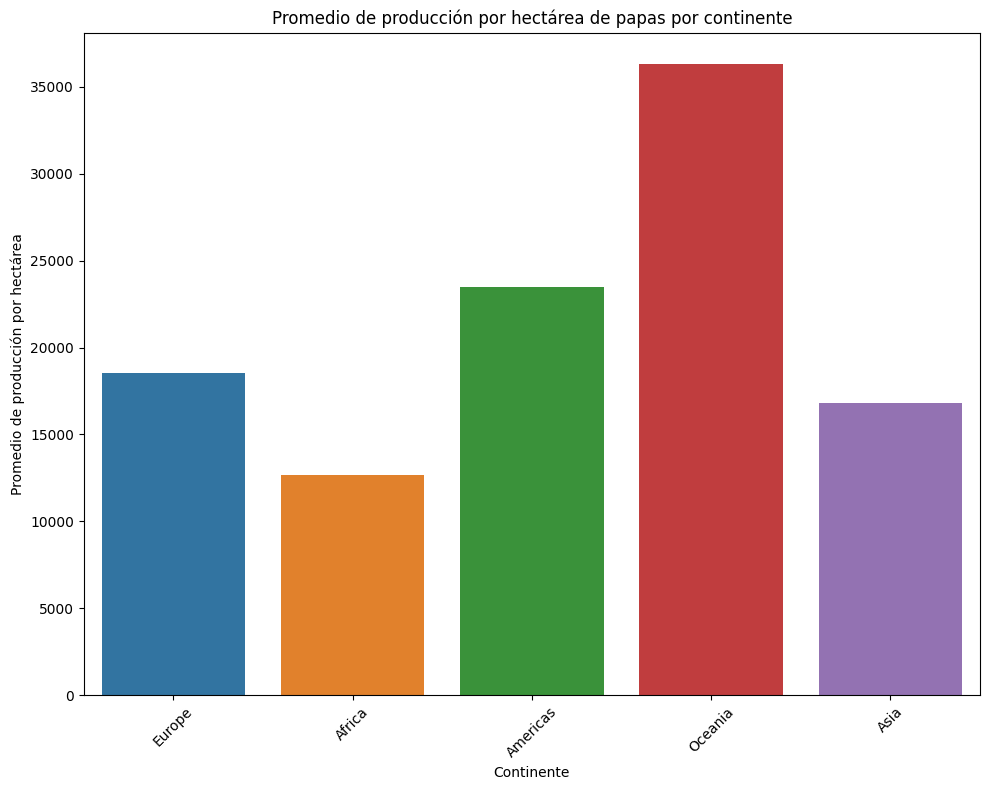

In [22]:
plt.figure(figsize=(10, 8))
sns.barplot(data=df_papa.toPandas(), x="Area", y="promedio_produccion_por_hectarea",hue="Area")
plt.xlabel("Continente")
plt.ylabel("Promedio de producción por hectárea")
plt.title("Promedio de producción por hectárea de papas por continente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* Oceania lidera el promedio de producción por hectárea, seguida por America y Europa.

* Africa y Asia presentan valores más bajos, mostrando que la eficiencia por hectárea es menor en esos continentes.

* Esto puede reflejar diferencias en tecnología agrícola, fertilización, riego y clima.

***Ahora se analizará la cantidad de animales bovinos producidos, se hará por continente y a lo largo de los años***

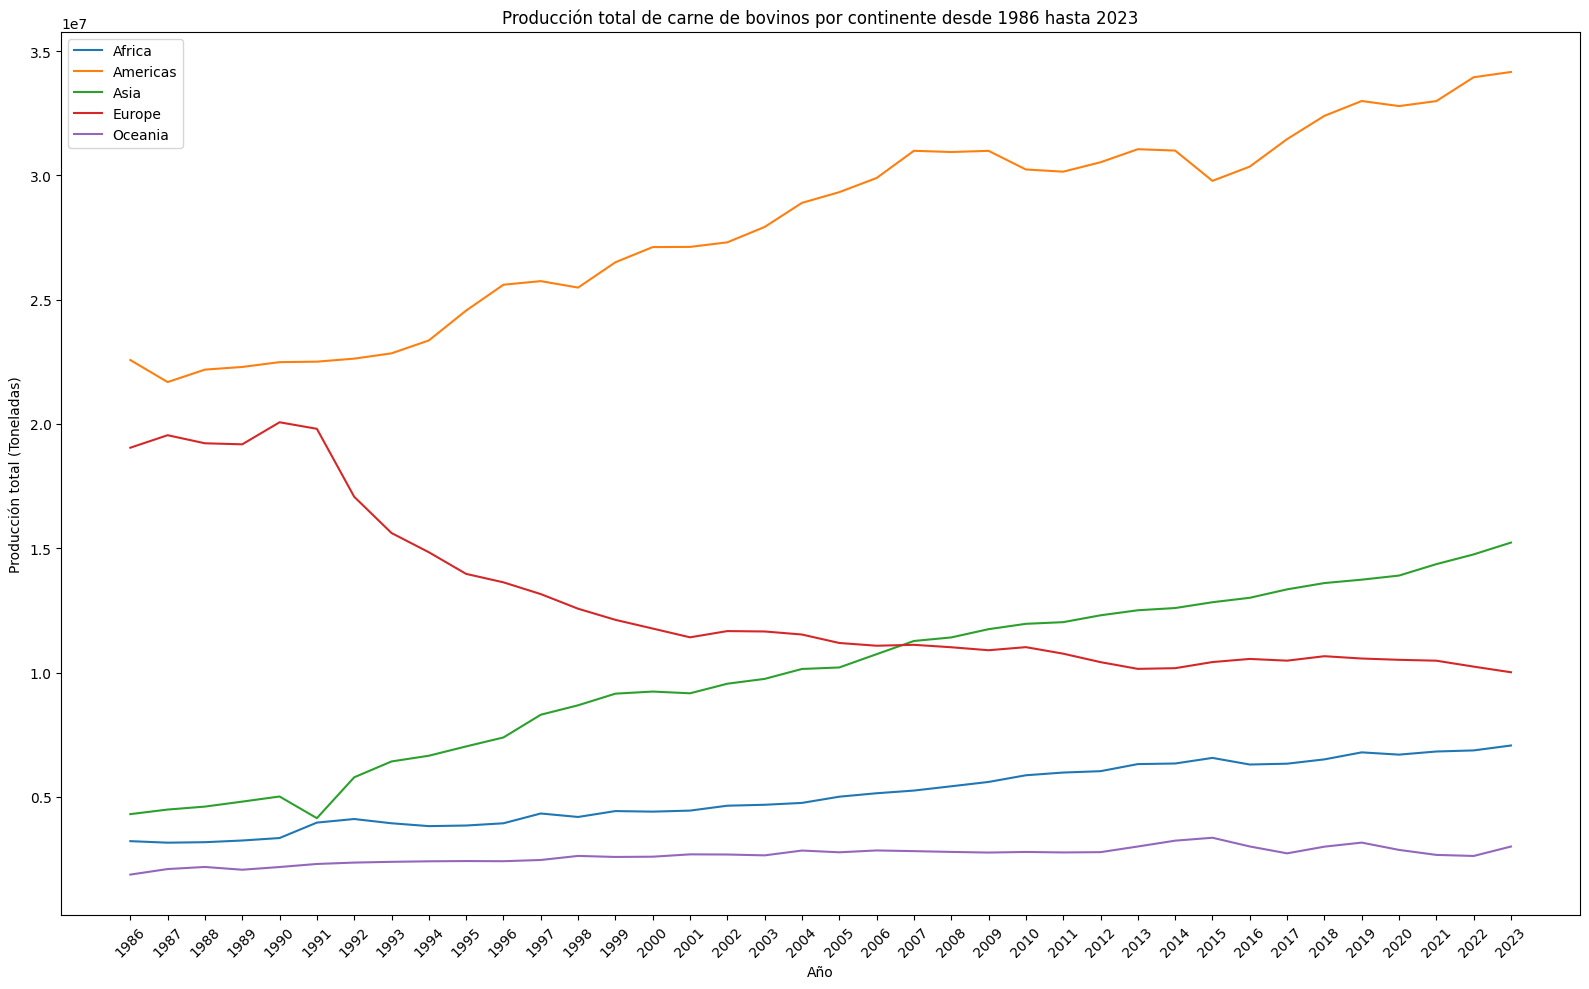

In [23]:
df_animales_carne = df_filtrado.filter((df_filtrado["Element"] == "Production") & (df_filtrado["Item"] == "Meat of cattle with the bone, fresh or chilled"))
continente = ["Americas","Asia","Europe","Africa","Oceania"]
df_animales_carne = df_animales_carne.filter(df_animales_carne["Area"].isin(continente))
df_animales_carne = df_animales_carne.select("Area", functions.expr(expr))
#Visualización
plt.figure(figsize=(16,10))
sns.lineplot(data=df_animales_carne.toPandas(), x="Year", y="value", hue="Area")
plt.xlabel("Año")
plt.ylabel("Producción total (Toneladas)")
plt.title("Producción total de carne de bovinos por continente desde 1986 hasta 2023")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()


* America y Asia muestran el mayor volumen total de producción, mientras que Africa y Oceania son mucho menores.

* Europa tiene una producción estable pero decreciente en los últimos años.

* Esto refleja la importancia de América y Asia en la producción global de carne bovina, posiblemente por extensas áreas de pastoreo y demanda interna.

In [24]:
df_filtrado.select("Item").distinct().show()

+--------------------+
|                Item|
+--------------------+
|         Canary seed|
|Meat of other dom...|
|                Bees|
|             Turkeys|
| Sheep and Goat Meat|
|          Pineapples|
|            Potatoes|
|Roots and Tubers,...|
|Edible offals of ...|
|Peppermint, spear...|
|         Kapok fruit|
|        Jojoba seeds|
|Raw hides and ski...|
|        Green garlic|
|       Coffee, green|
|Edible offal of b...|
|Onions and shallo...|
|         Blueberries|
|         Cocoa beans|
|                 Rye|
+--------------------+
only showing top 20 rows



***Producción total de arroz desde 1986 hasta 2023***


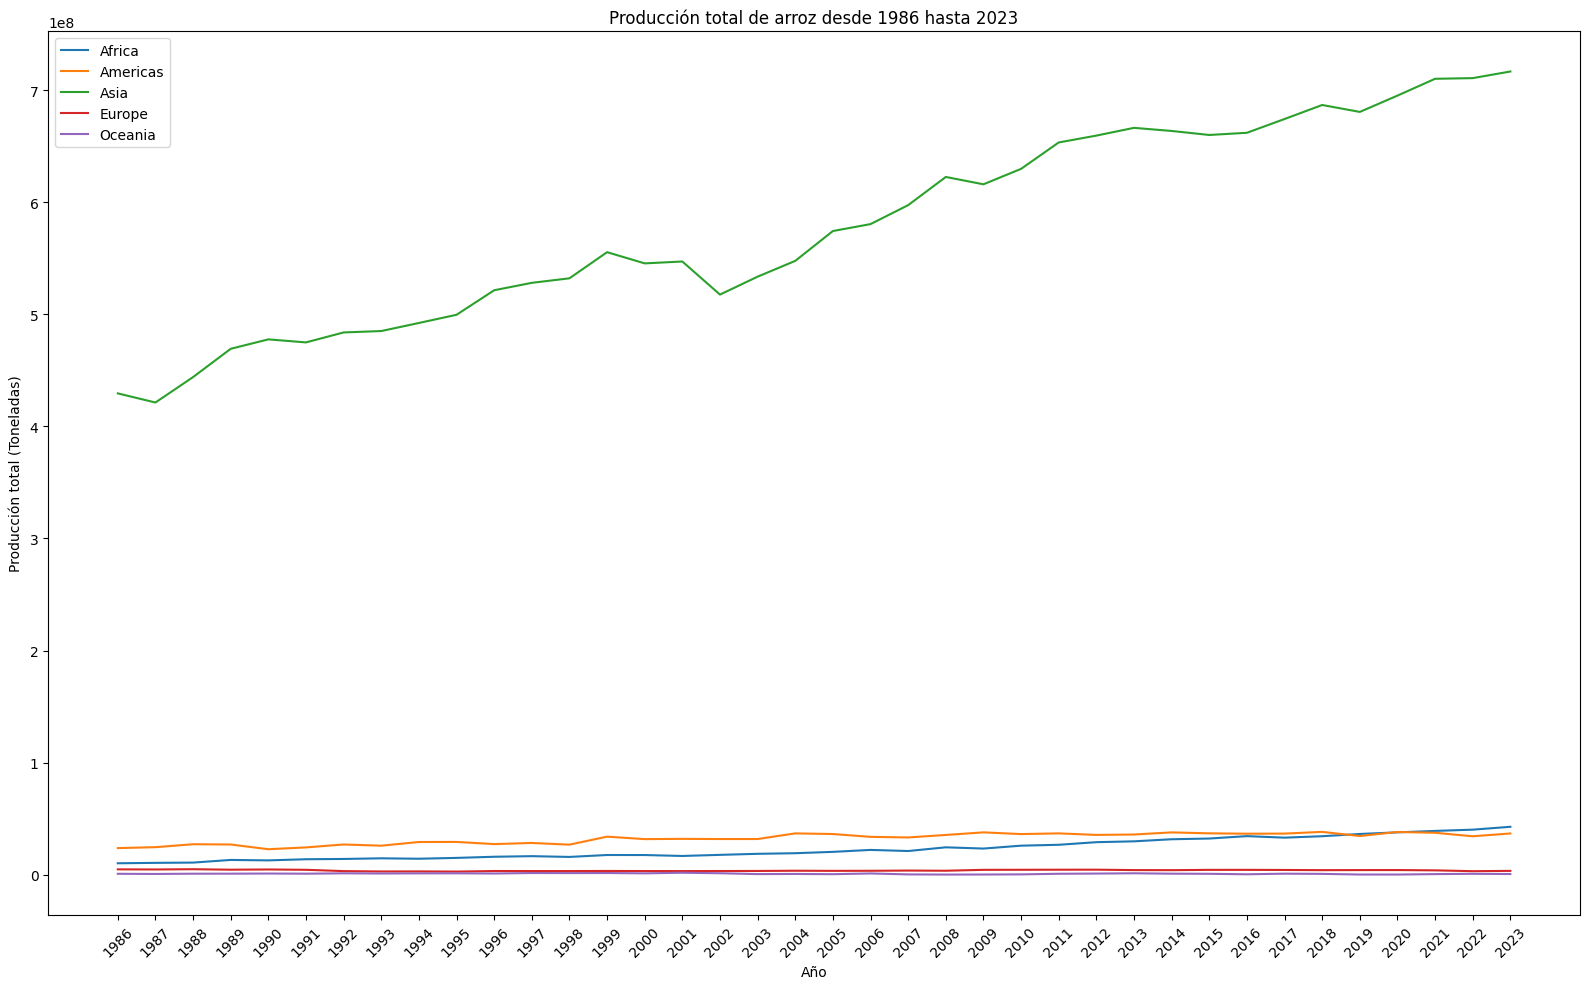

In [25]:
df_arroz = df_filtrado.filter((df_filtrado["Item"] == "Rice") & (df_filtrado["Element"] == "Production") & (df_filtrado["Element Code"] == 5510))
continente = ["Americas","Asia","Europe","Africa","Oceania"]
df_arroz_carne = df_arroz.filter(df_animales_carne["Area"].isin(continente))
df_arroz_anual = df_arroz_carne.select("Area", functions.expr(expr))
plt.figure(figsize=(16,10))
sns.lineplot(data=df_arroz_anual.toPandas(), x="Year", y="value", hue="Area")
plt.xlabel("Año")
plt.ylabel("Producción total (Toneladas)")
plt.title("Producción total de arroz desde 1986 hasta 2023")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

* Asia domina claramente la producción de arroz, con valores muy superiores a los otros continentes.

* America tiene producción moderada, y Oceania y Africa son los de menor participación.

* Esto coincide con la realidad agrícola mundial, donde Asia concentra la mayoría de la producción de arroz debido a clima y tradición de cultivo.

***Promedio de producción de arroz por país***

In [26]:
df_arroz_por_pais = df_arroz.select("Area", functions.expr(expr))
df_arroz_avg = df_arroz_por_pais.groupBy("Area").mean("value")
df_arroz_avg = df_arroz_avg.withColumnRenamed("avg(value)", "Promedio_produccion")
df_mapa_arroz = df_arroz_avg.toPandas()
fig = px.choropleth(
    df_mapa_arroz,
    locations="Area",
    locationmode="country names",
    color="Promedio_produccion",
    color_continuous_scale="YlOrRd",
    title="Promedio de producción de arroz por país",
    width=1400,    # ancho en píxeles
    height=900     # alto en píxeles
)
fig.show()


* Se observa que China, India y algunos países del sudeste asiático tienen la mayor producción promedio.

* Otros países muestran producción baja o moderada.

* El mapa permite identificar visualmente los principales productores de arroz a nivel global, destacando la concentración en Asia.

***Proporción de área cultivada total por continente (el analisis se hará para el año inicial(1986) que hay datos, 10 años después(1996),20 años después(2006),30 años después(2016) y finalmente para 2023).***

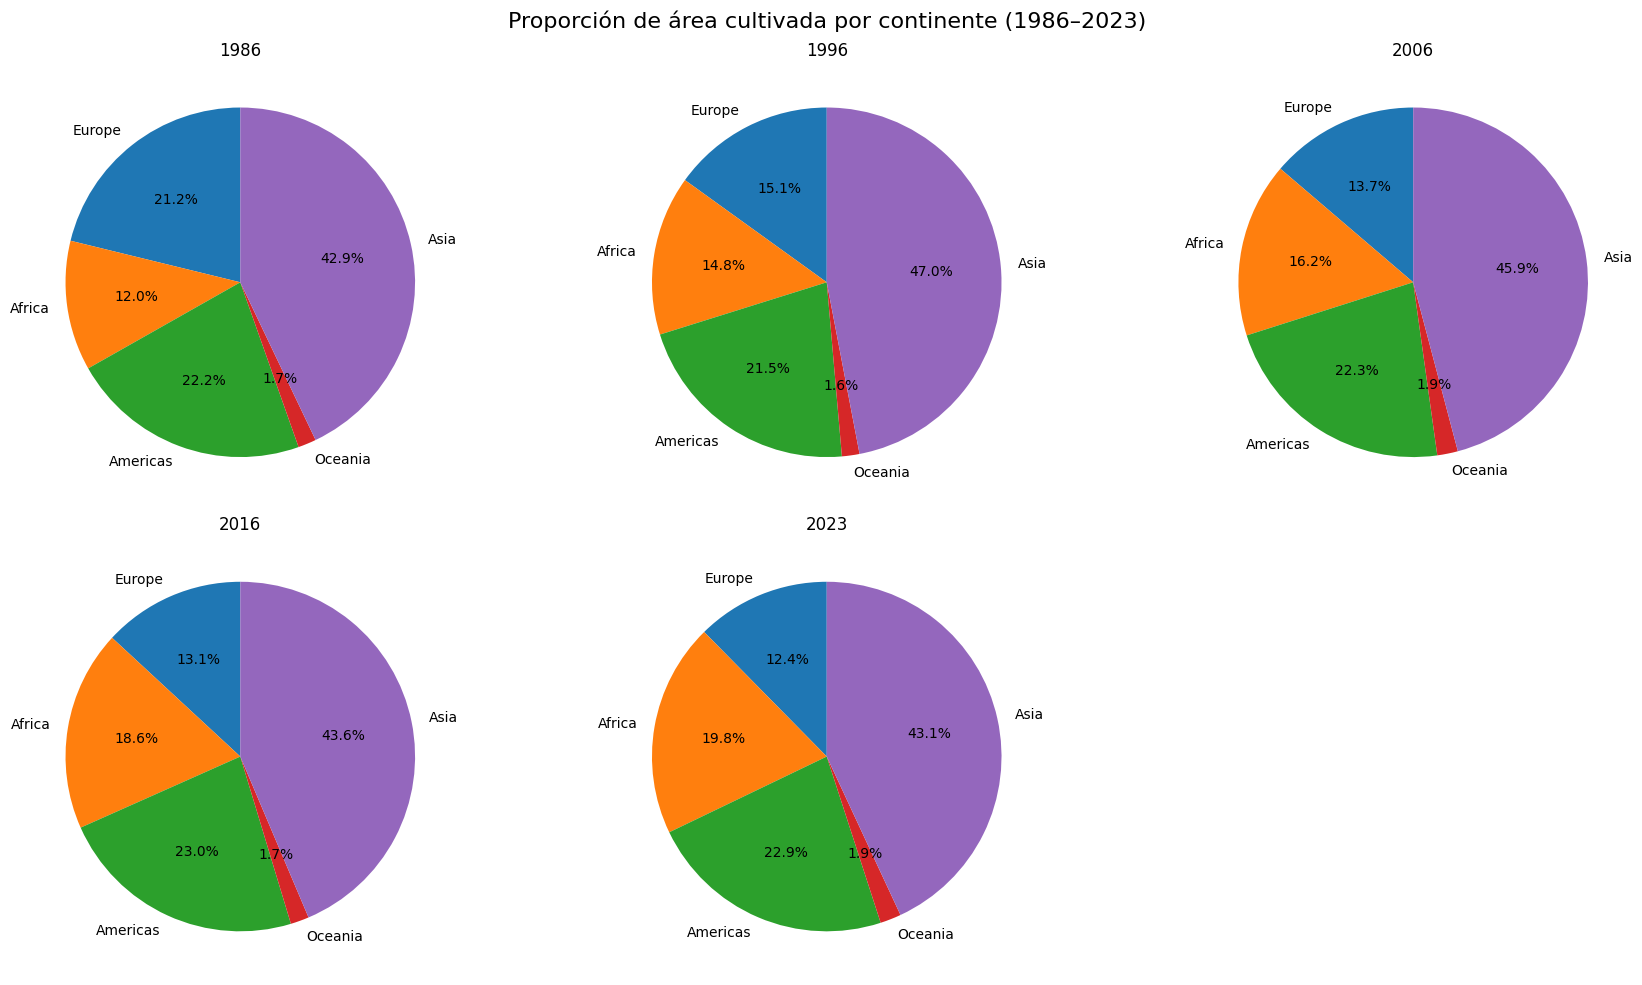

In [27]:
def area_cultivada_por_anio_multiple(anios: list[int]):
    """
    Muestra gráficos de pastel del área cultivada por continente para varios años.
    """
    # Crear figura con 5 subgráficas
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, anio in enumerate(anios):
        # --- Procesamiento de datos para cada año ---
        df_area_cultivada_anio = df_area_cultivada.select("Area", str(anio))
        df_area_cultivada_anio_por_continente = df_area_cultivada_anio.filter(df_area_cultivada_anio["Area"].isin(continente))
        df_area_cultivada_anio_por_continente = df_area_cultivada_anio_por_continente.groupBy("Area").sum(str(anio))
        df_area_cultivada_anio_por_continente = df_area_cultivada_anio_por_continente.withColumnRenamed(f"sum({anio})", "Suma area cultivada")

        # Convertir a pandas
        df_plot = df_area_cultivada_anio_por_continente.toPandas()

        # --- Gráfico de pastel ---
        axes[i].pie(
            df_plot["Suma area cultivada"],
            labels=df_plot["Area"],
            autopct='%1.1f%%',
            startangle=90
        )
        axes[i].set_title(f"{anio}", fontsize=12)

    # Eliminar subplot vacío si sobran espacios
    for j in range(len(anios), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Proporción de área cultivada por continente (1986–2023)", fontsize=16)
    plt.tight_layout()
    plt.show()


# Llamada
area_cultivada_por_anio_multiple([1986, 1996, 2006, 2016, 2023])


* Asia mantiene la mayor proporción de área cultivada en todos los años, aunque su participación presenta ligeras variaciones (alrededor del 43–47%).

* Europa muestra una disminución constante en su proporción, pasando de cerca del 21% en 1986 a alrededor del 12% en 2023, lo que sugiere una reducción de su actividad agrícola relativa.

* África presenta un aumento sostenido, pasando de aproximadamente 12% a casi 20%, lo que indica una expansión de las tierras agrícolas.

* América se mantiene relativamente estable, con una leve tendencia al alza (de ~22% a ~23%).

* Oceanía conserva una proporción muy pequeña (1.6–1.9%), sin cambios relevantes.

A lo largo de las décadas, la agricultura se ha desplazado proporcionalmente hacia África y Asia, mientras que Europa ha reducido su participación en el área cultivada mundial.

***Promedio de producción de pollo por país***

In [28]:
df_pollo = df_filtrado.filter((df_filtrado["Item"] == "Meat of chickens, fresh or chilled") & (df_filtrado["Element"] == "Production") & (df_filtrado["Element Code"] == 5510))
df_pollo_promedio = df_pollo.select("Area", functions.expr(expr))
df_pollo_promedio = df_pollo_promedio.groupBy("Area").mean("value")
df_pollo_promedio = df_pollo_promedio.withColumnRenamed("avg(value)", "Promedio_produccion")


In [29]:
df_mapa_pollo = df_pollo_promedio.toPandas()
fig = px.choropleth(
    df_mapa_pollo,
    locations="Area",
    locationmode="country names",
    color="Promedio_produccion",
    color_continuous_scale="Oranges",
    title="Promedio de producción de pollo por país",
    width=1400,    # ancho en píxeles
    height=900     # alto en píxeles
)
fig.show()


* Los mayores productores se ubican en América del Norte (especialmente EE. UU.), Asia (China e India) y partes de Sudamérica (Brasil y Argentina).

* Europa presenta una producción intermedia, mientras que África, Oceanía y algunos países de Asia central y del norte de Europa muestran niveles bajos o mínimos.